In [1]:
%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Setting Matplotlib defaults
plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(8,5), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<Figure size 1440x900 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv', index_col='id')

org = pd.read_csv("/kaggle/input/calories-burnt-prediction/calories.csv", index_col='User_ID')
org = org.rename(columns={'Gender': 'Sex'})

In [3]:
train = pd.concat([train, org], ignore_index=True)

In [4]:
strt_cols = list(test.columns)
print(train.drop_duplicates(subset=strt_cols + ['Calories']).shape, train.shape)

(762107, 8) (765000, 8)


# Data Understanding

In [5]:
train.shape

(765000, 8)

In [6]:
test.shape

(250000, 7)

In [7]:
train.head(10)

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
5,female,26,156.0,56.0,19.0,100.0,40.5,103.0
6,female,21,172.0,73.0,3.0,81.0,38.3,9.0
7,male,46,188.0,94.0,23.0,100.0,40.8,145.0
8,female,33,166.0,63.0,25.0,107.0,40.5,161.0
9,male,65,185.0,88.0,23.0,104.0,41.0,185.0


In [8]:
train.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000
mean,41.447255,174.693126,75.142162,15.423163,95.484672,40.036041,88.307424
std,15.213677,12.854173,14.004122,8.353421,9.452476,0.779863,62.396760
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [9]:
train.isnull().sum()

Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [10]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  object
 1   Age         765000 non-null  int64
 2   Height      765000 non-null  float64
 3   Weight      765000 non-null  float64
 4   Duration    765000 non-null  float64
 5   Heart_Rate  765000 non-null  float64
 6   Body_Temp   765000 non-null  float64
 7   Calories    765000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 47.4+ MB


# Data Preprocessing

## Reducing memory usage

In [11]:
train['Age'] = train['Age'].astype('int8')
test['Age'] = test['Age'].astype('int8')

In [12]:
num_cols = test.select_dtypes(include='float64').columns
for col in num_cols:
    train[num_cols] = train[num_cols].astype('float32')
    test[num_cols] = test[num_cols].astype('float32')

In [13]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Sex         765000 non-null  object
 1   Age         765000 non-null  int8
 2   Height      765000 non-null  float32
 3   Weight      765000 non-null  float32
 4   Duration    765000 non-null  float32
 5   Heart_Rate  765000 non-null  float32
 6   Body_Temp   765000 non-null  float32
 7   Calories    765000 non-null  float64
dtypes: float32(5), float64(1), int8(1), object(1)
memory usage: 27.7+ MB


# Feature Understanding via Data Visualization

In [14]:
mapping = {'male': 1, 'female': 0}

train['Sex'] = train['Sex'].map(mapping).astype('int8')
test['Sex'] = test['Sex'].map(mapping).astype('int8')

In [15]:
train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189.0,82.0,26.0,101.0,41.000000,150.0
1,0,64,163.0,60.0,8.0,85.0,39.700001,34.0
2,0,51,161.0,64.0,7.0,84.0,39.799999,29.0
3,1,20,192.0,90.0,25.0,105.0,40.700001,140.0
4,0,38,166.0,61.0,25.0,102.0,40.599998,146.0


In [16]:
features = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [17]:
def add_features(df):
    for i, c1 in enumerate(features):
        for c2 in (features[i+1:]):
            m = f'{c1}*{c2}'
            df[m] = df[c1] * df[c2]  
            #a = f'{c1}+{c2}'
            #df[a] = df[c1] + df[c2]
            d = f'{c1}/{c2}'
            df[d] = df[c1] / (df[c2] + 1e-3)
    return df

In [18]:
def feature_engineer(df):
    df['Max_Heart_Rate'] = 207 - (0.7 * df['Age'])
    df['HR_Ratio'] = df['Heart_Rate'] / df['Max_Heart_Rate']
    df['HR_Reserve'] = (df['Heart_Rate'] / df['Max_Heart_Rate']) * df['Duration']

    df['MET_Estimate'] = (df['Heart_Rate'] / df['Max_Heart_Rate']) * 15
    df['MET_Calories_Rate'] = df['MET_Estimate'] * 3.5 * df['Weight'] / 200
    
    df['MET_Calories_Total'] = df['MET_Calories_Rate'] * df['Duration']
    
    df['Exercise_Intensity_Index'] = df['Heart_Rate'] * df['Body_Temp'] / (df['Weight'] * df['Age'])
    df['Intensity'] = df['Heart_Rate']  * df['Duration'] / 60

    df['exertion_score'] = df['Duration'] * df['Heart_Rate'] * df['Body_Temp']
    
    df['BMI'] = df['Weight'] / (df['Height']/100) ** 2

    for col in ['Duration', 'Heart_Rate']:
        df[f'Sqrt_{col}'] = np.sqrt(df[col])
    
    df['body_theta'] = np.arctan2(df['Weight'], df['Height'])

    return df

In [19]:
X = train.copy()
y = X.pop('Calories')
y = np.log1p(y)
X = add_features(X)
X = feature_engineer(X)

X_test = test.copy()
X_test = add_features(X_test)
X_test = feature_engineer(X_test)

In [20]:
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=100)

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'alpha': trial.suggest_float('alpha', 1e-3, 3, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'eval_metric': 'rmse',
        'tree_method':'gpu_hist',
        'device':'cuda',
    }

    scores = []
    for fold, (train_index, valid_index) in enumerate(kf.split(X, y), start=1):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        xgb = XGBRegressor(**params, early_stopping_rounds=50, random_state=100).fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
        xgb_pred = xgb.predict(X_valid)
        fold_rmse = np.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(xgb_pred)))
        scores.append(fold_rmse)

    return np.mean(scores)
    
    
study = optuna.create_study(direction='minimize', study_name='XGB-RMSE-Optimization')
study.optimize(objective, n_trials=12)

print(f'Best cross-validation RMSE: {study.best_value:,.5f}')
print(f'Best parameters: {study.best_params}')

[I 2025-05-18 08:28:20,651] A new study created in memory with name: XGB-RMSE-Optimization
[I 2025-05-18 08:29:10,562] Trial 0 finished with value: 0.05983755473828627 and parameters: {'n_estimators': 1922, 'learning_rate': 0.13706530017961452, 'max_depth': 8, 'min_child_weight': 14, 'alpha': 1.3917727608456671, 'lambda': 0.254823944361449, 'subsample': 0.8320161812670614, 'colsample_bytree': 0.5575311972250603, 'gamma': 4.229112582943264e-06}. Best is trial 0 with value: 0.05983755473828627.
[I 2025-05-18 08:30:43,853] Trial 1 finished with value: 0.05983818907943226 and parameters: {'n_estimators': 1848, 'learning_rate': 0.05994496964497653, 'max_depth': 3, 'min_child_weight': 6, 'alpha': 0.03222969630832153, 'lambda': 0.0014091021163195278, 'subsample': 0.7384461560027877, 'colsample_bytree': 0.6202814119131147, 'gamma': 1.7451884151493887e-06}. Best is trial 0 with value: 0.05983755473828627.
[I 2025-05-18 08:32:39,854] Trial 2 finished with value: 0.05949003709675721 and parameter

Best cross-validation RMSE: 0.05936
Best parameters: {'n_estimators': 1040, 'learning_rate': 0.0192981967413957, 'max_depth': 9, 'min_child_weight': 1, 'alpha': 0.006042585885451827, 'lambda': 0.2540083918669999, 'subsample': 0.9449758858378732, 'colsample_bytree': 0.7312650173383709, 'gamma': 6.273805765337343e-08}


In [21]:
with open('/kaggle/working/best_xgb_params.json', 'w') as f:
    json.dump(study.best_params, f)

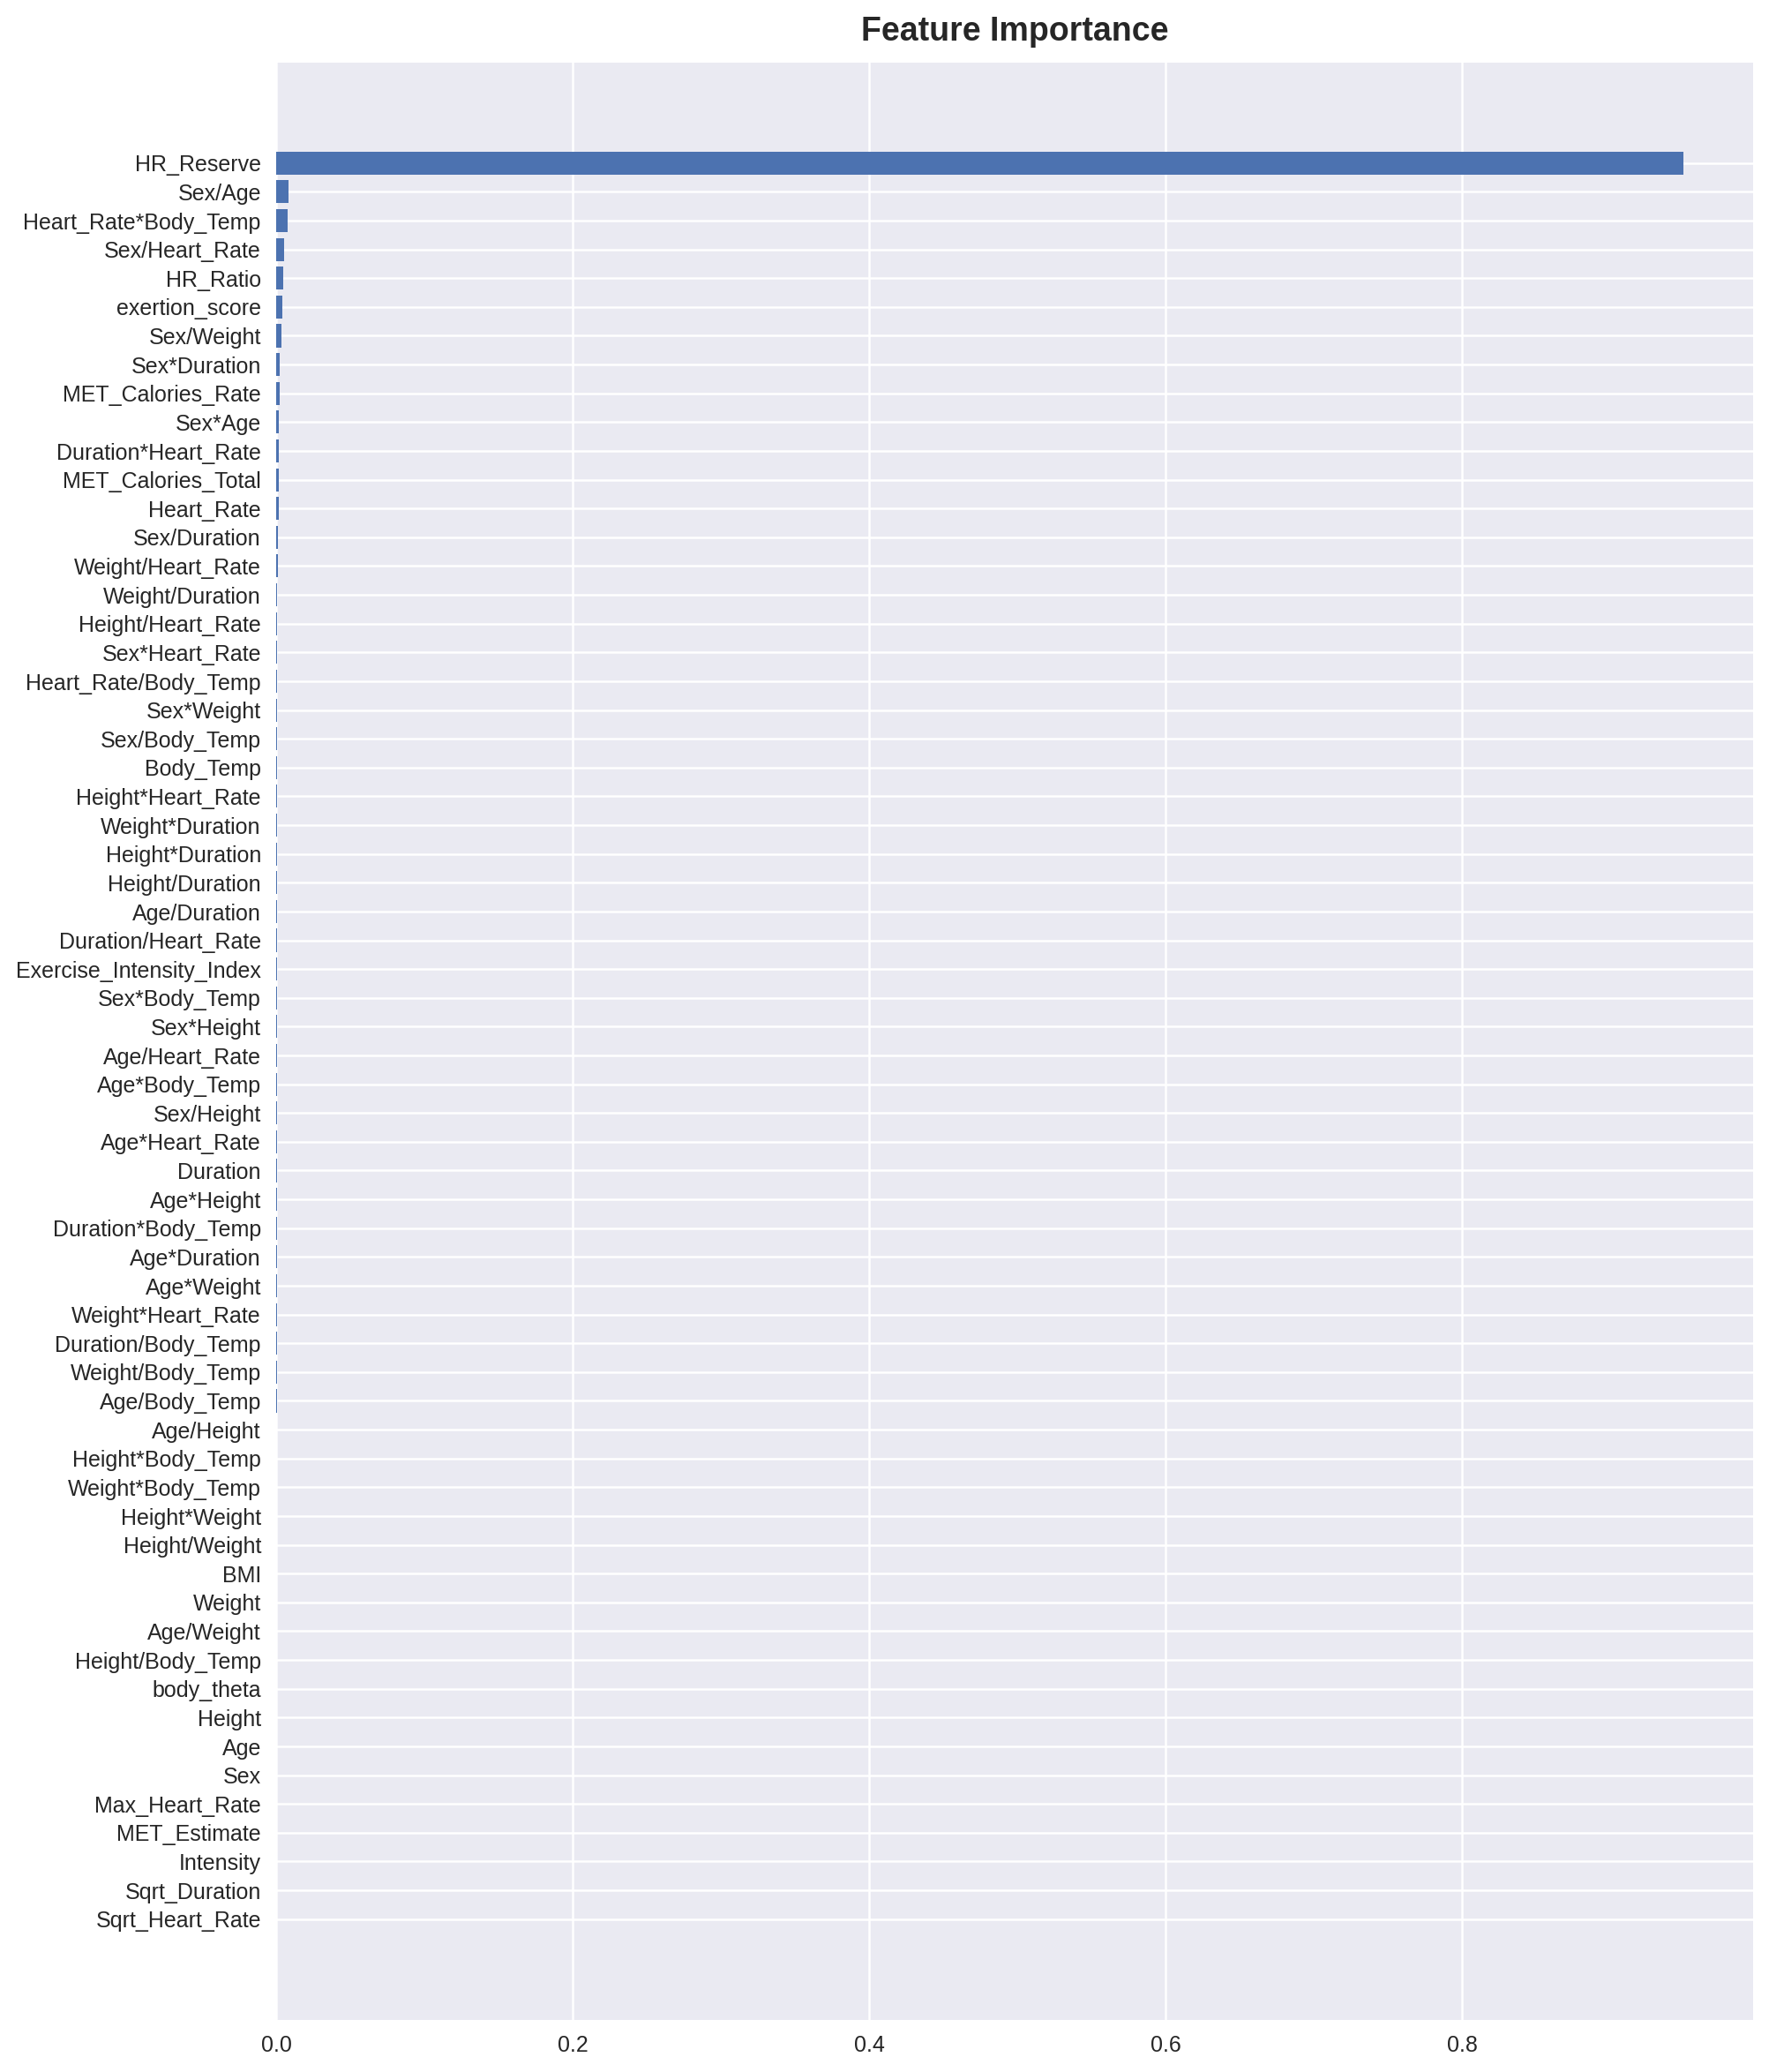

In [22]:
from xgboost import XGBRegressor

xgb = XGBRegressor().fit(X, y)

importances = xgb.feature_importances_
columns = X.columns
df_importances = pd.DataFrame({'Feature': columns, 'Importance': importances})
df_importances = df_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 16))
plt.barh(df_importances['Feature'], df_importances['Importance'])
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [23]:
final_model = XGBRegressor(**study.best_params).fit(X, y)
test_xgb = final_model.predict(X_test)
test_xgb  = np.expm1(test_xgb)
y_preds = np.clip(test_xgb, 1, 314)

sub = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
sub['Calories'] = y_preds
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(sub.head(6))

Your submission was successfully saved!
       id    Calories
0  750000   27.326490
1  750001  107.822205
2  750002   87.387032
3  750003  125.963509
4  750004   75.451973
5  750005   21.741089
